In [82]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

In [59]:
df =  pd.read_csv('Electric.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df.head(3)

,DATE,Value
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502


In [ ]:
df.set_index('DATE', inplace=True) #set date as index
df

## **visualize the series**

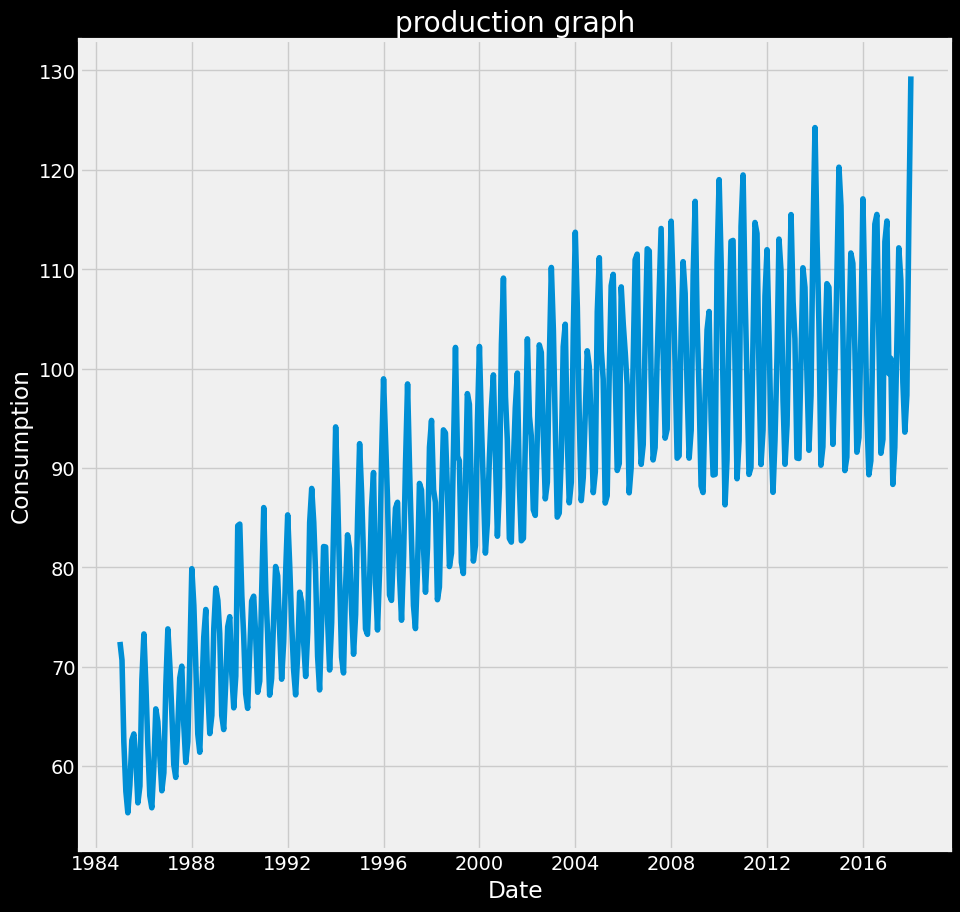

In [64]:
plt.figure(figsize=(10,10), clear=True, dpi=100, facecolor='black')
plt.xlabel("Date", fontdict={'color': "white"})
plt.ylabel("Consumption", fontdict={'color': "white"})
plt.title("production graph", fontdict={'color': "white"})
plt.plot(df)

###* for time series forecast the series need to be stationary,(no trend)
###* The series need to have a constant mean, variance and covariance

## **Converting data to stationery**

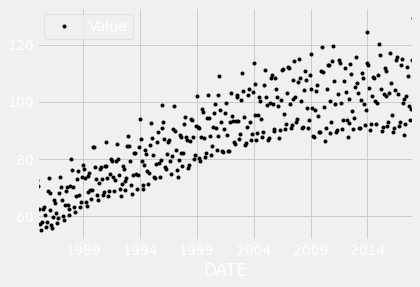

In [76]:
df.plot(style='k.')
plt.show()

### A given time series is thought to consist of three systematic components including <b>level, trend, seasonality</b> and one non-systematic component called <b>noise</b>
### *Level: The average value in the series.
### *Trend: The increasing or decreasing value in the series.
### *Seasonality: The repeating short-term cycle in the series.
### *Noise: The random variation in the series.
### In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

### **Using statsmodels.tsa.seasonal to separate Trend and Seasonality**

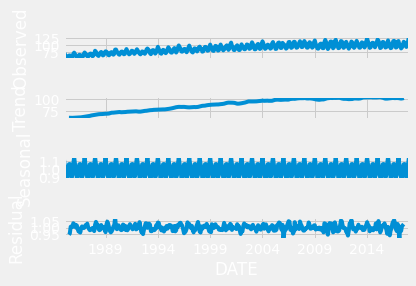

In [87]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()

### **Stationarizing the timeseries**

### *First chech if data is stationery we use <b> ADF (Augmented Dickey-Fuller) Test</b>
### **Null Hypothesis**: The series has a unit root (value of a =1)
### **Alternate Hypothesis**: The series has no unit root.
### If we fail to reject the null hypothesis, we can say that the series is non-stationary. 
### If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary. ***makes the null hypothesis false***

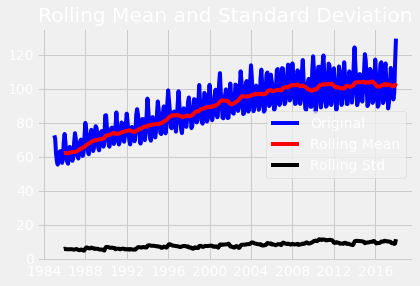

****Results of dickey fuller test****

Test Statistics                 -2.256990
p-value                          0.186215
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


In [92]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(timeseries):
  #Determing rolling statistics
  rolmean = timeseries.rolling(12).mean()
  rolstd = timeseries.rolling(12).std()
  #Plot rolling statistics:
  plt.plot(timeseries, color='blue',label='Original')
  plt.plot(rolmean, color='red', label='Rolling Mean')
  plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation')
  plt.show(block=False)
  #perform dickey fuller test  
  print("****Results of dickey fuller test****\n")
  adft = adfuller(timeseries['Value'],autolag='AIC')
  # output for dft will give us values without defining the labels.
  #hence we manually write what values does it explains using a for loop
  output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
  for key,values in adft[4].items():
      output['critical value (%s)'%key] =  values
  print(output)


test_stationary(df)


### **We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.**

### To get a stationary series, we need to eliminate the trend and seasonality from the series.

### 1. taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series.
### 2.we find the rolling average of the series.

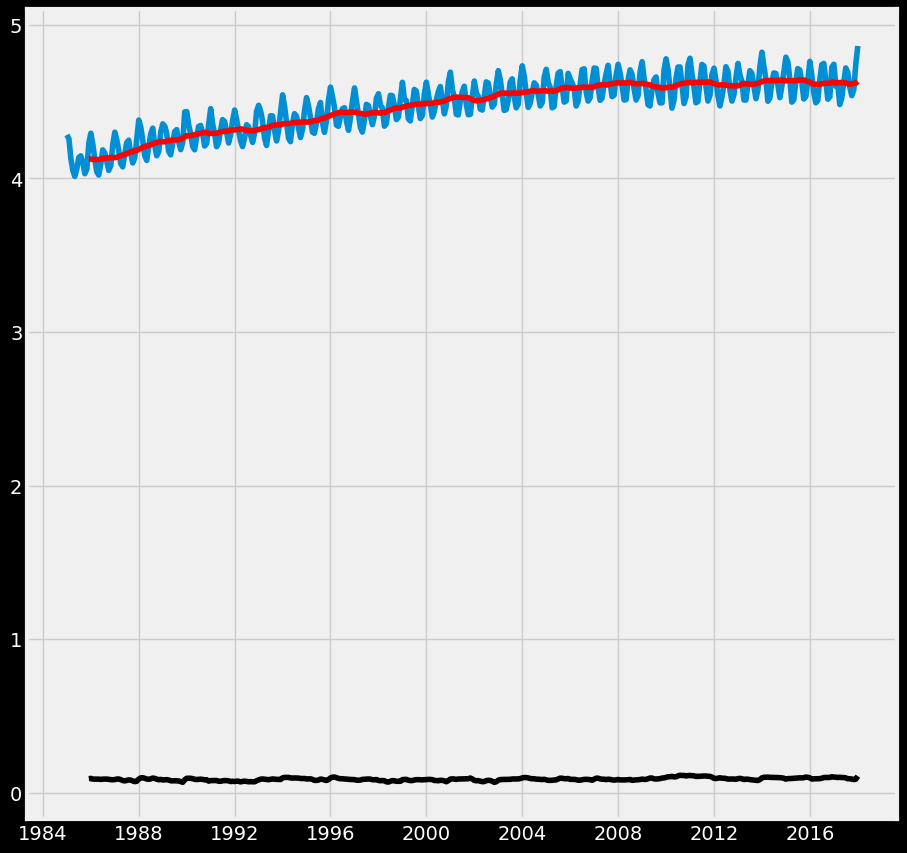

In [97]:
# getting log for the value
df_log = np.log(df)
# getting the moving averages and std dev
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
# plotting the data
plt.figure(figsize=(10,10), dpi=100, facecolor='black', frameon=True)
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

### After finding the mean, we take the difference of the series and the mean at every point in the series. (x,y) levels

### This way, we eliminate trends out of a series and obtain a more stationary series.

In [98]:
#getting the difference of values in log and moving average values
df_log_moving_avg_diff = df_log-moving_avg
#dropping empty values
df_log_moving_avg_diff.dropna(inplace=True)

### **Perform the Dickey-Fuller test (ADFT) once again. We have to perform this function every time to check whether the data is stationary or not.**

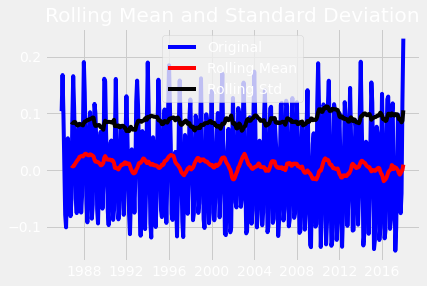

****Results of dickey fuller test****

Test Statistics                 -5.211586
p-value                          0.000008
No. of lags used                15.000000
Number of observations used    370.000000
critical value (1%)             -3.448148
critical value (5%)             -2.869383
critical value (10%)            -2.570948
dtype: float64


In [99]:
test_stationary(df_log_moving_avg_diff)

### **We need to check the weighted average, to understand the trend of the data in time series**

In [100]:
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()

### *** Take df_log and subtract with weighted_average and perform the Dickey-Fuller test (ADFT) once again.***

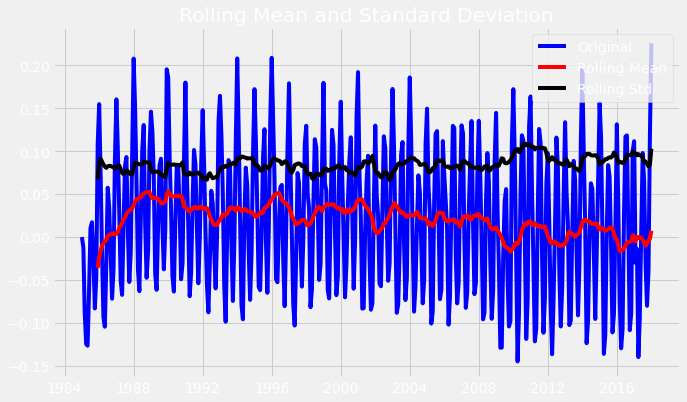

****Results of dickey fuller test****

Test Statistics                 -3.251531
p-value                          0.017189
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


In [101]:
#getting the difference of df-log and the weighted average
logScale_weightedMean = df_log-weighted_average

from pylab import rcParams
rcParams['figure.figsize'] = 10,6
test_stationary(logScale_weightedMean)

### From the above graph, we observed that the data attained stationarity. We also see that the test statistics and critical value is relatively equal.

### There can be cases when there is a high seasonality in the data.

### In those cases, just removing the trend will not help much. We need to also take care of the seasonality in the series. One such method for this task is differencing.

### Differencing is a method of transforming a time series dataset.

### It can be used to remove the series dependence on time, so-called temporal dependence.

### **Differencing is performed by subtracting the previous observation from the current observation**

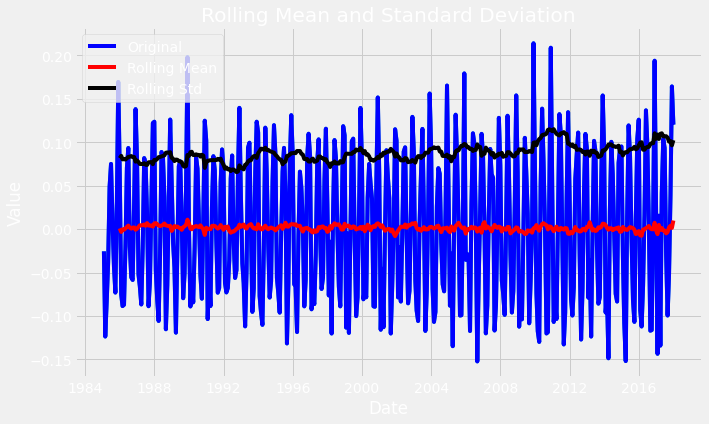

****Results of dickey fuller test****

Test Statistics               -6.748333e+00
p-value                        2.995161e-09
No. of lags used               1.400000e+01
Number of observations used    3.810000e+02
critical value (1%)           -3.447631e+00
critical value (5%)           -2.869156e+00
critical value (10%)          -2.570827e+00
dtype: float64


In [103]:
df_log_diff = df_log - df_log.shift()

#plotting the data
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Value")
plt.plot(df_log_diff)#Let us test the stationarity of our resultant series
df_log_diff.dropna(inplace=True)
test_stationary(df_log_diff)

### The next step is to perform decomposition which provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these component

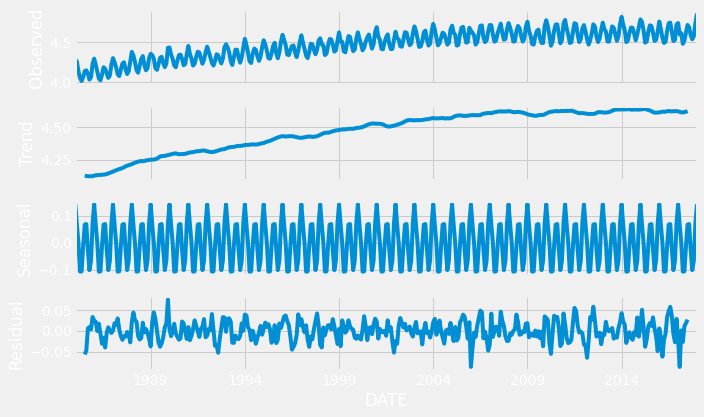

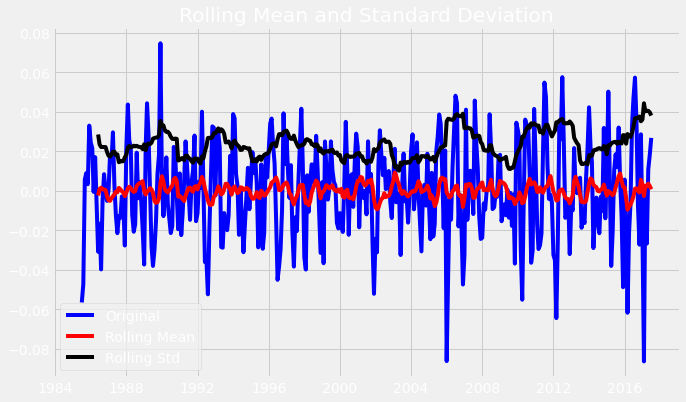

****Results of dickey fuller test****

Test Statistics               -1.000311e+01
p-value                        1.861632e-17
No. of lags used               1.400000e+01
Number of observations used    3.700000e+02
critical value (1%)           -3.448148e+00
critical value (5%)           -2.869383e+00
critical value (10%)          -2.570948e+00
dtype: float64


In [108]:
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_log, model='additive', freq = 12)
result.plot()
plt.show()

trend = result.trend
trend.dropna(inplace=True)

seasonality = result.seasonal
seasonality.dropna(inplace=True)

residual = result.resid
residual.dropna(inplace=True)

test_stationary(residual)

### **3. Finding the best parameters for our model**

### Before we go on to build our forecasting model, we need to determine optimal parameters for our model. For those optimal parameters, we need ACF and PACF plots
### A nonseasonal ARIMA model is classified as an “ARIMA(p,d,q)” model, where:

### p → Number of autoregressive terms,

### d → Number of nonseasonal differences needed for stationarity, and

### q → Number of lagged forecast errors in the prediction equation.

### Values of p and q come through ACF and PACF plots. So let us understand both ACF and PACF!

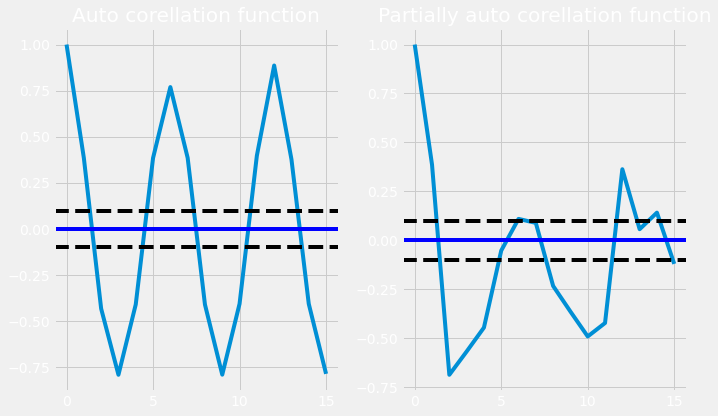

In [109]:
from statsmodels.tsa.stattools import acf,pacf
# we use d value here(data_log_shift)

acf = acf(df_log_diff, nlags=15)
pacf= pacf(df_log_diff, nlags=15,method='ols')#plot PACF
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')

plt.tight_layout()#plot ACF
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

### **4. Fitting model**

### In order to find the p and q values from the above graphs, we need to check, where the graph cuts off the origin or drops to zero for the first time from the above graphs the p and q values are merely close to 3 where the graph cuts off the origin ( draw the line to x-axis) now we have p,d,q values. So now we can substitute in the ARIMA model and let's see the output.

RSS : 0.522731



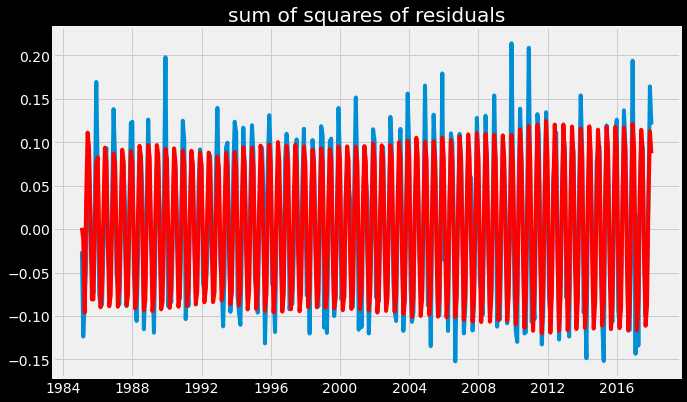

In [113]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df_log, order=(3,1,3))
result_AR = model.fit(disp = 0)
plt.figure(facecolor='black')
plt.plot(df_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.title("sum of squares of residuals")

print('RSS : %f\n' %sum((result_AR.fittedvalues-df_log_diff["Value"])**2))

### **5. Predictions**

### The following code helps us to forecast shampoo sales for the next 6 years.

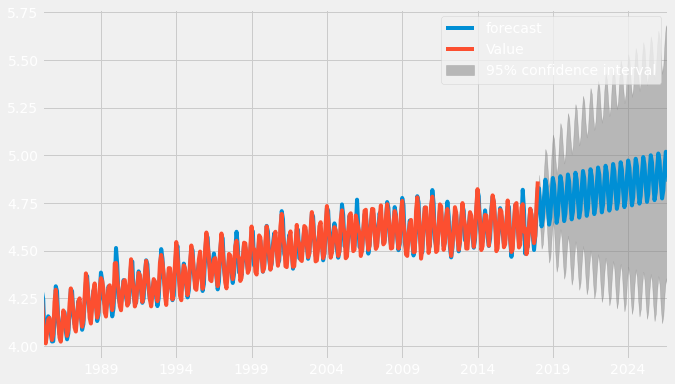

In [117]:
result_AR.plot_predict(1,500 )
x=result_AR.forecast(steps=200)